# Inference using Fisher Analysis: Power Spectrum

**Authors**: Sambit K. Giri, Adelie Gorce, Ian Hothi <br>
**Date created**: 3 June 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import h5py, sys, os, wget
from astropy.cosmology import Planck18 as cos
from astropy import units, constants
from tqdm import tqdm

## Simulation data

The data has been simulated using 21cmFast. The XY plane has an extent of 250Mpc, with 256 pixels on each side. The line-of-sight (redshift) has been simulated to be between z = 8.82 (144.60 MHz) and z = 9.33 (137.46 MHz), comprising 128 frequency channels. The three astrophysical parameters chosen to be changed are the virial temperature ($T_{vir}$), maximum distance travelled by ionising photons ($R_{max}$), and the ionising efficiency parameter ($\zeta$)—these were all found to have the strongest impact on the signal. See [Hothi et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024A%26A...686A.212H/abstract) for more detail.

These are the parameter variations (fiducial value $\pm$ change):<br>
- $T_{vir}$: $50000\pm 5000$
- $R_{max}$: $15\pm 5 Mpc$
- $\zeta$  : $30\pm 5$

Information about the simulation run:<br>
- 400 simulations were run for each parameter value, which will be used for the derivatives.
- In the loaded files, there will be two files for each parameter: one corresponding to the plus value—for example, for $T_{vir}$​, the value would be 50000+5000—and one corresponding to the minus value, which would be 50000−5000.
- 400 simulations were run with the fiducial value, which will be used to calculate the covariances of the statistics.

In [2]:
nsims = 400

### Astrophysical parameters

In [3]:
# Astro params
params = ['ION_Tvir_MIN','R_BUBBLE_MAX','HII_EFF_FACTOR']
nparams = len(params)
delta_params = [1e4,10,10]

### Download and/or load data

The simulation data is downloaded if the not found in the data directory.

In [4]:
# data_link = 'https://21ssd.obspm.fr/21ssd///SKA_Chapter_simulations/'
data_link = 'https://ttt.astro.su.se/~sgiri/data/SKA_chapter_simulations/'

data_dir = './SKA_chapter_simulations/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Folder created: {data_dir}")

sim_datafilenames = {
    'fiducial'     : 'Lightcone_FID_400_Samples.h5',
    'param_1_plus' : 'Lightcone_ION_Tvir_MIN_400_Samples_Plus.h5',
    'param_1_minus': 'Lightcone_ION_Tvir_MIN_400_Samples_Minus.h5',
    'param_2_plus' : 'Lightcone_R_BUBBLE_MAX_400_Samples_Plus.h5',
    'param_2_minus': 'Lightcone_R_BUBBLE_MAX_400_Samples_Minus.h5',
    'param_3_plus' : 'Lightcone_HII_EFF_FACTOR_400_Samples_Plus.h5',
    'param_3_minus': 'Lightcone_HII_EFF_FACTOR_400_Samples_Minus.h5',
}
sim_datafiles = {ke: data_dir+itm for ke,itm in sim_datafilenames.items()}

In [5]:
sim_file = {}
sim_data = {}
for name,data_dir_fl in sim_datafiles.items():
    print(f'Data file: {data_dir_fl}')
    if not os.path.exists(data_dir_fl):
        data_link_fl = data_link+fl
        print(f'...downloading data from {data_link_fl}...')
        wget.download(data_link_fl, data_dir)
        print(f'...done')
    else:
        # Create a function that read the data when called providing the realisation number (0-399).
        # The data will be adjusted to make sure that the last axis is los
        sim_file[name] = data_dir_fl
        sim_data[name] = lambda i: np.swapaxes(h5py.File(sim_file[name],'r')['brightness_lightcone'][i,:,:,:],0,-1)
        print(f'...data found.')

Data file: ./SKA_chapter_simulations/Lightcone_FID_400_Samples.h5
...data found.
Data file: ./SKA_chapter_simulations/Lightcone_ION_Tvir_MIN_400_Samples_Plus.h5
...data found.
Data file: ./SKA_chapter_simulations/Lightcone_ION_Tvir_MIN_400_Samples_Minus.h5
...data found.
Data file: ./SKA_chapter_simulations/Lightcone_R_BUBBLE_MAX_400_Samples_Plus.h5
...data found.
Data file: ./SKA_chapter_simulations/Lightcone_R_BUBBLE_MAX_400_Samples_Minus.h5
...data found.
Data file: ./SKA_chapter_simulations/Lightcone_HII_EFF_FACTOR_400_Samples_Plus.h5
...data found.
Data file: ./SKA_chapter_simulations/Lightcone_HII_EFF_FACTOR_400_Samples_Minus.h5
...data found.


In [6]:
# Read h5py file to obtain metadata
with h5py.File(sim_datafiles['fiducial'], 'r') as f:
    frequencies = f['frequencies'][...]      # frequencies along the lightcone
    redshifts   = f['redshifts'][...]        # redshifts along the lightcone
    box_length  = float(f['box_length'][0])  # Mpc
    ngrid       = int(f['ngrid'][0])         # number of pixels along the sky patch
    nrand       = int(f['nrealisations'][0]) # number of realisations for a given parameter set
nfreq = frequencies.size
print(f'Lightcone runs from z={redshifts.min():.2f} to z = {redshifts.max():.2f}.')
# This is important to estimate as the third or los axis has a different physical length.
box_length_los = np.abs(cos.comoving_distance(redshifts.max())-cos.comoving_distance(redshifts.min())).value

Lightcone runs from z=8.82 to z = 9.33.


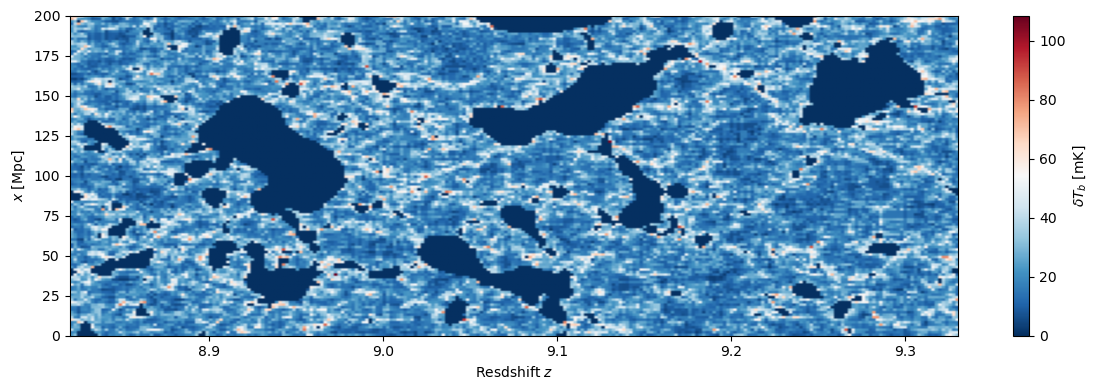

In [7]:
lc = sim_data['fiducial'](0)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
im = ax.imshow(
    lc[10,:,:].T,
    extent=(redshifts.min(), redshifts.max(), 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'Resdshift $z$')
ax.set_ylabel(r'$x$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
fig.tight_layout()

### SKA-Low noise simulator

The simulator for modelling the instrumental noise from different SKA-Low telescope layout using [tools21cm](https://tools21cm.readthedocs.io/).

Note that the noise simulator takes a long time during the first run as it calculates the weights corresponding to the SKA-low observation in the $uv$ space at different frequencies. This calculation is saved in a file, making the later run very fast.

In [8]:
import tools21cm as t2c

In [9]:
# SKA obs parameters
obs_time = 1000.     # hours
int_time = 10.       # seconds
total_int_time = 6.  # hours per day
declination = -30.0  # declination of the field in degrees
bmax = 2. * units.km # km

In [10]:
subarray_type_list = ["AAstar", "AA4"]
noise_simulator = {}
noise_lc = {}

for subarray_type in subarray_type_list:
    save_uvmap = data_dir+f'uvmap_{subarray_type}_{total_int_time}h_perday.h5'
    print(f'The uv weight maps will be saved as {save_uvmap}') 
    
    # noise lightcone simulator
    noise_simulator[subarray_type] = lambda : t2c.noise_lightcone(
        ncells=ngrid,
        zs=redshifts,
        obs_time=obs_time,
        total_int_time=total_int_time,
        int_time=int_time,
        declination=declination,
        subarray_type=subarray_type,
        boxsize=box_length,
        verbose=False,
        save_uvmap=save_uvmap,  # save uv coverage to re-use for each realisation
        n_jobs=1, #4,
        checkpoint=16,
    )  # third axis is line of sight
    
    # generate noise lightcone
    noise_lc[subarray_type] = noise_simulator[subarray_type]()
    print(subarray_type, np.std(lc), np.std(noise_lc[subarray_type]))

The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AAstar_6.0h_perday.h5
Creating the uv maps.


100%|██████████| 128/128 [00:00<00:00, 487178.69it/s]

Creating noise...


AAstar 14.55155012190993 2284.8689283675417
The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AA4_6.0h_perday.h5
Creating the uv maps.


100%|██████████| 128/128 [00:00<00:00, 528416.25it/s]

Creating noise...


AA4 14.55155012190993 779.905550803046


In [11]:
noisy_lc = {ke: noise_lc[ke] + t2c.subtract_mean_signal(lc, los_axis=2)
            for ke in noise_lc.keys()}
dt_obs = {}
for i,subarray_type in enumerate(subarray_type_list): 
    dt_obs[subarray_type], zs_obs = t2c.smooth_lightcone(
        noisy_lc[subarray_type], 
        redshifts, 
        box_size_mpc=box_length,
        max_baseline=2.0, #km
    )

100%|██████████| 128/128 [00:02<00:00, 51.17it/s]


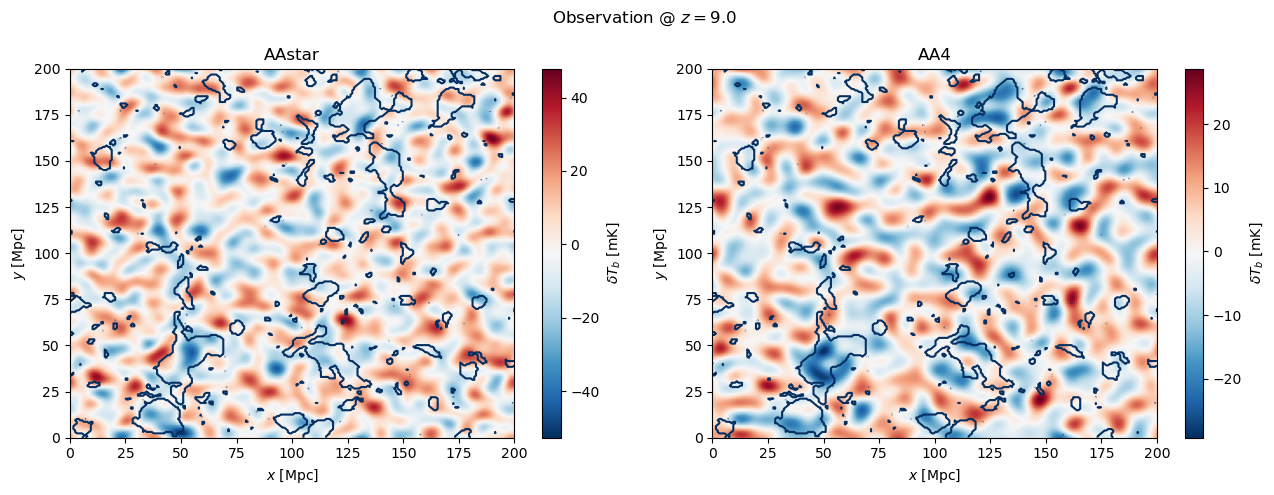

In [12]:
iz = np.abs(redshifts-9).argmin()

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(rf'Observation @ $z={redshifts[iz]:.1f}$')
for i,subarray_type in enumerate(subarray_type_list): 
    ax = axs[i]
    im = ax.imshow(
        dt_obs[subarray_type][..., iz],
        extent=(0, box_length, 0, box_length),
        origin='lower', cmap='RdBu_r', aspect='auto',
        # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
        )
    xi = np.linspace(0, box_length, ngrid)
    ax.contour(xi, xi, lc[...,iz], levels=[1e-4], cmap="RdBu_r")
    ax.set_xlabel(r'$x$ [Mpc]')
    ax.set_ylabel(r'$y$ [Mpc]')
    fig.colorbar(im, ax=ax, label=r'$\delta T_b$ [mK]')
    ax.set_title(rf'{subarray_type}')
fig.tight_layout()

### Compute summary statistics

The summary statistics is computed for the several realisation of simulation data by adding noise.

In [13]:
summary_dir = data_dir+'PowerSpectra/'
if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)
    print(f"Folder created: {summary_dir}")
print(f'The summary statistics saved in {summary_dir}')

box_dims = [box_length, box_length, box_length_los]
print(f'Simulation volume lengths = {lc.shape} cells or {box_dims} Mpc')

The summary statistics saved in ./SKA_chapter_simulations/PowerSpectra/
Simulation volume lengths = (256, 256, 128) cells or [200.0, 200.0, np.float64(126.46180362562882)] Mpc


**Nyquist frequency** is the highest frequency that can be accurately represented in a discrete signal, and it is equal to half the sampling frequency.

$k_\mathrm{nyquist} = \frac{\pi}{L_\mathrm{box}}N_\mathrm{grid}$

However, [Mao et al. (2012)](https://arxiv.org/abs/1104.2094) found that the signal can be trusted only below $k_\mathrm{nyquist}/2$ due to **aliasing**.

In [14]:
k_min = 2*np.pi/box_length
k_nyquist = k_min*ngrid/2
print(f'Nyquist frequency = {k_nyquist:.2f} 1/Mpc')

kbins = 15 #10
kbin_edges = 10**np.linspace(np.log10(k_min), np.log10(k_nyquist/2), kbins+1)
print(f'k-bin edges: {kbin_edges}')

Nyquist frequency = 4.02 1/Mpc
k-bin edges: [0.03141593 0.04145356 0.05469831 0.07217485 0.09523528 0.12566371
 0.16581425 0.21879322 0.28869939 0.38094112 0.50265482 0.66325702
 0.87517288 1.15479754 1.52376449 2.0106193 ]


In [15]:
summary_data = {}
for name,data_rd in sim_data.items(): #zip(['fiducial'],[sim_data['fiducial']]):#
    filename = summary_dir+sim_datafilenames[name].split('.h5')[0]+f'_{kbins}_kbins.h5'
    print(filename)
    if not os.path.exists(filename):
        summary_data[name] = {'AA4': np.zeros((nsims,kbins)), 'AAstar': np.zeros((nsims,kbins))}
        for i in tqdm(range(nsims), desc=f'{name}'):
            lc_i = sim_data[name](i)
            nn_AAstar = noise_simulator['AAstar']()
            dt_AAstar = t2c.subtract_mean_signal(lc_i, los_axis=2)+nn_AAstar
            ps_AAstar, ks_AAstar = t2c.power_spectrum_1d(dt_AAstar, kbins=kbin_edges, box_dims=box_dims)
            nn_AA4 = noise_simulator['AA4']()
            dt_AA4 = t2c.subtract_mean_signal(lc_i, los_axis=2)+nn_AA4
            ps_AA4, ks_AA4 = t2c.power_spectrum_1d(dt_AA4, kbins=kbin_edges, box_dims=box_dims)
            summary_data[name]['AAstar'][i,:] = ps_AAstar
            summary_data[name]['AA4'][i,:] = ps_AA4
            summary_data[name]['k'] = ks_AAstar
        t2c.write_dictionary_data(summary_data[name], filename)
        print('...summary data saved')
    else:
        summary_data[name] = t2c.read_dictionary_data(filename)
        print('...summary data read')
                                                      

./SKA_chapter_simulations/PowerSpectra/Lightcone_FID_400_Samples_15_kbins.h5
...summary data read
./SKA_chapter_simulations/PowerSpectra/Lightcone_ION_Tvir_MIN_400_Samples_Plus_15_kbins.h5
...summary data read
./SKA_chapter_simulations/PowerSpectra/Lightcone_ION_Tvir_MIN_400_Samples_Minus_15_kbins.h5
...summary data read
./SKA_chapter_simulations/PowerSpectra/Lightcone_R_BUBBLE_MAX_400_Samples_Plus_15_kbins.h5
...summary data read
./SKA_chapter_simulations/PowerSpectra/Lightcone_R_BUBBLE_MAX_400_Samples_Minus_15_kbins.h5
...summary data read
./SKA_chapter_simulations/PowerSpectra/Lightcone_HII_EFF_FACTOR_400_Samples_Plus_15_kbins.h5
...summary data read
./SKA_chapter_simulations/PowerSpectra/Lightcone_HII_EFF_FACTOR_400_Samples_Minus_15_kbins.h5
...summary data read


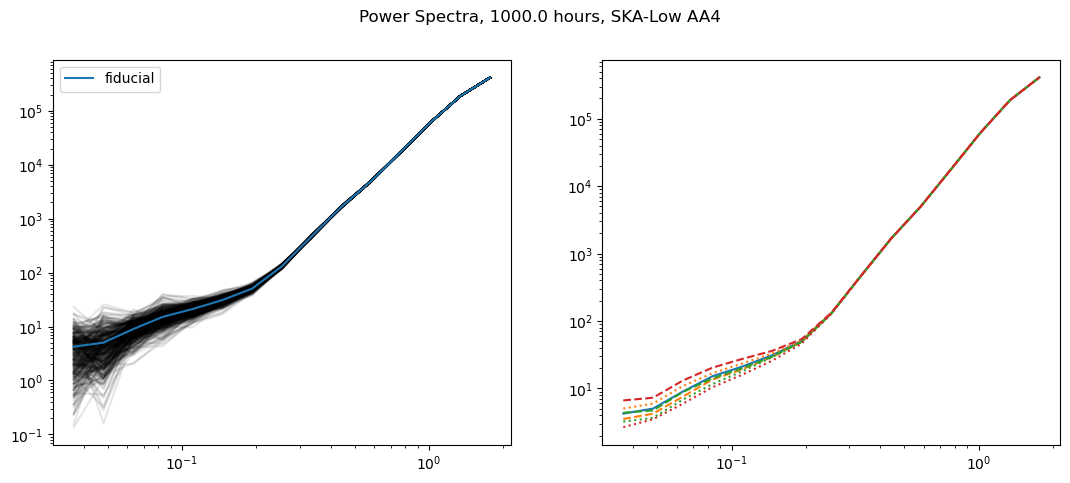

In [16]:
subarray_type = 'AA4'
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(rf'Power Spectra, {obs_time} hours, SKA-Low {subarray_type}')
name = 'fiducial'
for i in range(nsims):
    axs[0].loglog(summary_data[name]['k'], summary_data[name][subarray_type][i,:]*summary_data[name]['k']**3/2/np.pi**2,
              c='k', alpha=0.1, label=None)
axs[0].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C0', label=f'{name}')
axs[0].legend()
name = 'fiducial'
axs[1].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C0', label=f'{name}')
name = 'param_1_plus'
axs[1].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C1', ls='--', label=f'{name}')
name = 'param_1_minus'
axs[1].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C1', ls=':', label=f'{name}')
name = 'param_2_plus'
axs[1].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C2', ls='--', label=f'{name}')
name = 'param_2_minus'
axs[1].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C2', ls=':', label=f'{name}')
name = 'param_3_plus'
axs[1].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C3', ls='--', label=f'{name}')
name = 'param_3_minus'
axs[1].loglog(summary_data[name]['k'], summary_data[name][subarray_type].mean(axis=0)*summary_data[name]['k']**3/2/np.pi**2,
              c='C3', ls=':', label=f'{name}')
axs[0].legend()

In the above plot, we do not see a spread due to noise at small-scales (large k) due to the log plot. Note that the noise bias has not been remove, but the derivative calculated for the Fisher matrix should cancel out this bias.

## Fisher Analysis

Under the assumption that the likelihood is a multivariate Gaussian (mean vectors are sufficient information for the covariance matrix), the Fisher matrix is defined as:

$$F^\theta_{ij} = \frac{\partial \textbf{S}}{\partial\theta_i} \mathbf{\Sigma}^{-1} \frac{\partial \textbf{S}}{\partial\theta_j},$$

where  $\frac{\partial \textbf{S}}{\partial\theta_i}$ is the change in statistic S under a change in paramrter i of $\partial\theta_j$. Here, $\mathbf{\Sigma}$ is the the covariance matrix, given my the fiducial simulation set.

### Compute partial derivatives

Let us first calculate $\frac{\partial \textbf{S}}{\partial\theta_i}$ for out three astrophysical parameters:

In [17]:
PS1p = {subarray_type: summary_data['param_1_plus'][subarray_type] for subarray_type in subarray_type_list}
PS1m = {subarray_type: summary_data['param_1_minus'][subarray_type] for subarray_type in subarray_type_list}

PS2p = {subarray_type: summary_data['param_2_plus'][subarray_type] for subarray_type in subarray_type_list}
PS2m = {subarray_type: summary_data['param_2_minus'][subarray_type] for subarray_type in subarray_type_list}

PS3p = {subarray_type: summary_data['param_3_plus'][subarray_type] for subarray_type in subarray_type_list}
PS3m = {subarray_type: summary_data['param_3_minus'][subarray_type] for subarray_type in subarray_type_list}

ks = summary_data['fiducial']['k']

In [18]:
PS1p = {subarray_type: summary_data['param_1_plus'][subarray_type].mean(axis=0) for subarray_type in subarray_type_list}

dPS1 = {subarray_type: (PS1p[subarray_type] - PS1m[subarray_type]) / delta_params[0] for subarray_type in subarray_type_list}
dPS2 = {subarray_type: (PS2p[subarray_type] - PS2m[subarray_type]) / delta_params[1] for subarray_type in subarray_type_list}
dPS3 = {subarray_type: (PS3p[subarray_type] - PS3m[subarray_type]) / delta_params[2] for subarray_type in subarray_type_list}

PS_derivs = {subarray_type: np.concatenate((dPS1[subarray_type][None,...],dPS2[subarray_type][None,...],dPS3[subarray_type][None,...])) 
             for subarray_type in subarray_type_list}

### Compute the covariance

Let us whiten the data to get rid of any order of magnitude issues that may arise, and compute the covariance matrix:

In [19]:
## Whitening step ##
PS_fid = {subarray_type: summary_data['fiducial'][subarray_type] for subarray_type in subarray_type_list} 

std_fid = {subarray_type: np.std(PS_fid[subarray_type],axis=0) for subarray_type in subarray_type_list} 
white_fid = {subarray_type: PS_fid[subarray_type]/std_fid[subarray_type] for subarray_type in subarray_type_list} 

#The covariance
covariance = {subarray_type: np.cov(white_fid[subarray_type],rowvar=False) for subarray_type in subarray_type_list} 

# Whitening the derivatives
PS_derivs_white = {subarray_type: PS_derivs[subarray_type].reshape(nparams,-1)[...,None]/std_fid[subarray_type] for subarray_type in subarray_type_list}

# To check the condition of the covariance:
for subarray_type in subarray_type_list:
    log10_cond_num = np.log10(np.linalg.cond(covariance[subarray_type]))
    print(r'log10 of Condition Number of the covariance matrix: %.2f (should be <= 7)'%(log10_cond_num))

log10 of Condition Number of the covariance matrix: 0.91 (should be <= 7)
log10 of Condition Number of the covariance matrix: 0.96 (should be <= 7)


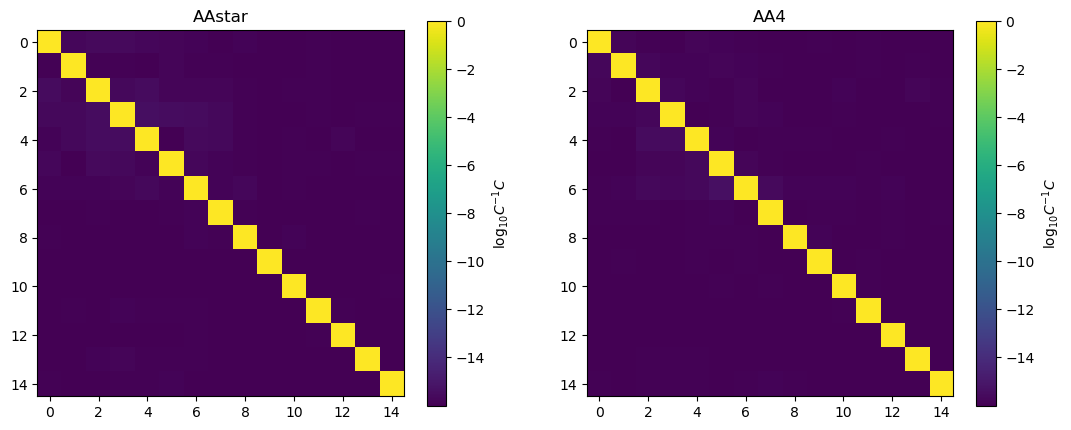

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
for i,subarray_type in enumerate(subarray_type_list):
    I = np.log10(abs(np.matmul(np.linalg.inv(covariance[subarray_type]),covariance[subarray_type]))+1e-16)
    im = axs[i].imshow(I)
    fig.colorbar(im, ax=axs[i], label='log$_{10} C^{-1}C$')
    axs[i].set_title(subarray_type)
plt.show()

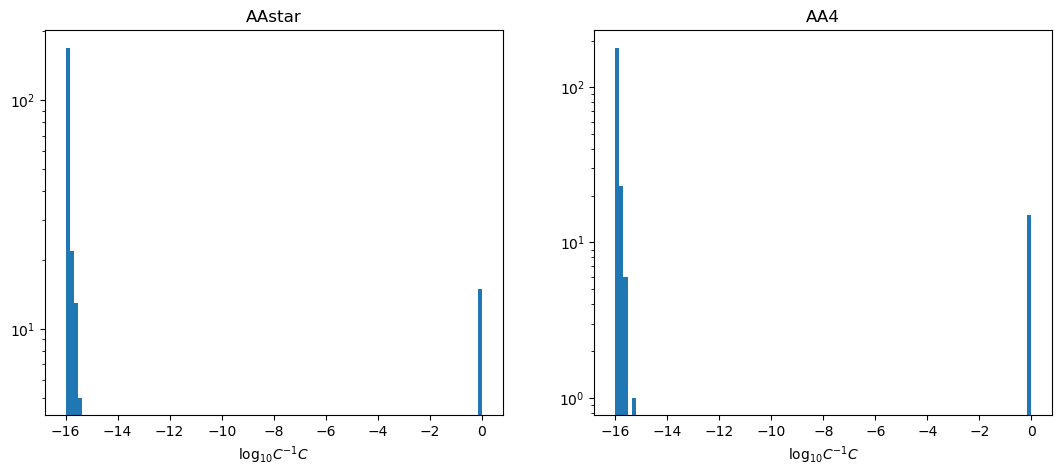

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
for i,subarray_type in enumerate(subarray_type_list):
    I = np.log10(abs(np.matmul(np.linalg.inv(covariance[subarray_type]),covariance[subarray_type]))+1e-16)
    axs[i].hist(I.reshape(-1), bins=100)
    axs[i].set_xlabel('log$_{10} C^{-1}C$')
    axs[i].set_yscale('log')
    axs[i].set_title(subarray_type)
plt.show()

### Compute the Fisher Matrix

We can now calculate the Fisher Matrix.

In [22]:
def get_fisher(derivatives, fiducial, nparams):
    """ Calculates the fisher matrix for different number of derivative samples. This function also 
        plots the 'identity' matrix derived for multiplying the covariance by its inverse - we also 
        include a histogram of this 'identity' matrix to see the zero-error.

    Parameters
    ----------
    derivatives : numpy.array
        An array containing the derivatives of a given statistic, with dimensions of 
        [nparams,nsamples,ncoefficients]
    fiducial : numpy.array
        Contains the fiducial simulation's statistic, with which we calculate the
        covariance. It has dimensions [nsamples,ncoefficients].
    nparams : int
        The number of parameters for which a derivative has been calculated.
    
    Returns
    -------
    Fisher : numpy.array
        Fisher matrix for a given number of sample used to calculate derivatives.
        Dimensions of [len(samples), nparams, nparams]
        
    Fisher_Inv : numpy.array
        Inverse of the Fisher matrix,having dimensions of [len(samples), nparams, nparams].
    samples : numpy.array
        Contains the number of samples of derivatives used to calculate Fisher and Fisher_Inv
    """
    import numpy
    # Maximum number of derivative samples that can be used 
    max_samples = len(derivatives[0])
    
    ## Whitening step ##
    std_fid = np.std(fiducial,axis=0)
    white_fid = fiducial/std_fid
    #The covariance
    covariance = np.cov(white_fid,rowvar=False)
    # Whitening the derivatives
    derivatives_white = derivatives.reshape((nparams,max_samples,-1))/std_fid
    print(('Condition Number: 10^%.3f')%(np.log10(np.linalg.cond(covariance))))
    # How many samples to use
    samples = np.arange(5,max_samples+50,5)
    # Initialising Fishers 
    Fisher = np.zeros((len(samples),nparams,nparams))
    Fisher_Inv = np.zeros((len(samples),nparams,nparams))

    # Calculating the Fisher matrix for a given sample of derivatives 
    for k,sample_size in enumerate(samples):
        deriv_sample = np.mean(derivatives_white[:,:sample_size,:],axis=1)
        F_ij = np.zeros((nparams,nparams))
        for i in range(nparams):
            for j in range(nparams):
                parm_i_ps = (deriv_sample)[i]
                parm_j_ps = (deriv_sample)[j]        
                FIJ = np.dot(parm_i_ps, np.dot(np.linalg.inv(covariance),parm_j_ps))
                F_ij[i,j] = FIJ
        F_ij_inv = np.linalg.inv(F_ij)  
        Fisher[k,:,:]= F_ij
        Fisher_Inv[k,:,:] = F_ij_inv
    return Fisher,Fisher_Inv,samples

In [23]:
# Get Fisher Matrix
PS_Fisher = {}
PS_Fisher_Inv = {}
for subarray_type in subarray_type_list:
    PS_Fisher[subarray_type], PS_Fisher_Inv[subarray_type], samples = get_fisher(
                                                    PS_derivs[subarray_type], 
                                                    PS_fid[subarray_type], 
                                                    nparams
                                                )



Condition Number: 10^0.912
Condition Number: 10^0.960


### Plot posterior

In [24]:
import corner

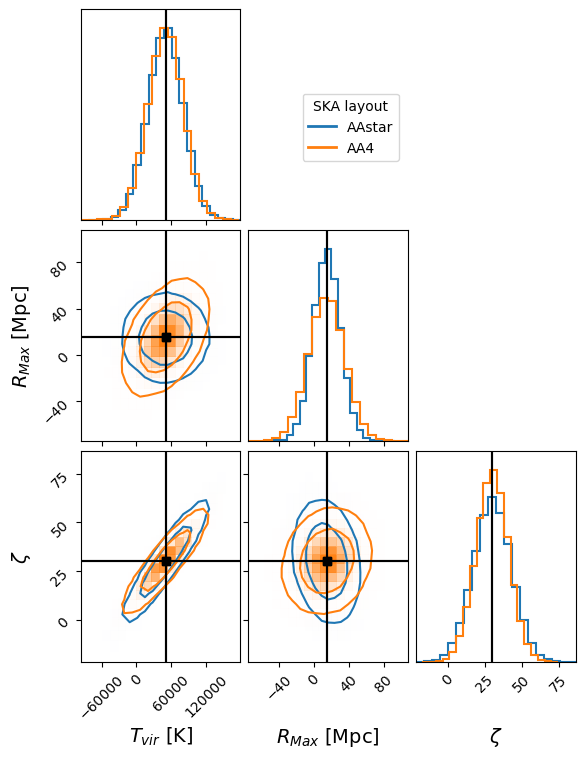

In [25]:
# Parameters
Fisher_Param = ['$T_{vir}$ [K]', '$R_{Max}$ [Mpc]', '$\\zeta$']
fid = [10**4.7, 15, 30]

fig = None
n_sampl = 100000
legend_handles = []

for i, subarray_type in enumerate(subarray_type_list):
    # Simulate Gaussian samples from Fisher covariance
    cov = PS_Fisher_Inv[subarray_type][-1]
    samples = np.random.multivariate_normal(fid, cov, size=n_sampl)
    
    # Add to corner plot
    fig = corner.corner(samples, 
                        fig=fig,
                        color=f'C{i}',
                        labels=Fisher_Param,
                        truths=fid,
                        truth_color='black',
                        show_titles=False,
                        plot_datapoints=False,
                        fill_contours=False,
                        levels=(0.68, 0.95),
                        hist_kwargs={"density": True, "lw": 1.5},
                        label_kwargs={"fontsize": 14},
                        smooth=0.1,
                        )

    # Collect legend proxy handles
    line = Line2D([0], [0], color=f'C{i}', lw=2)
    legend_handles.append((line, subarray_type))

# Resize
fig.set_size_inches(8, 8)

# Add legend outside
fig.subplots_adjust(right=0.75)  # Make space for legend
fig.legend(*zip(*legend_handles), 
           loc='center left', 
           bbox_to_anchor=(0.40, 0.80), 
           fontsize=10, 
           title="SKA layout")

plt.show()
